In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy
import pickle
import utils

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

In [36]:
FURNITURES = ['bed', 'bench', 'chair', 'table']
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 
FURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

LAYERS_NM = ['pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

In [3]:
# pulling/cleaning up the data

# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
SF = pickle.load(open('/tigress/rslee/SF.p', 'rb'))
DF = pickle.load(open('/tigress/rslee/DF.p', 'rb'))

In [4]:
# get labels
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[-2]

# extract metadata
path_to_sketches = '/home/rslee/sketch_data'
sketch_paths = list_files(path_to_sketches)
sketch_labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)

path_to_drawings = '/home/rslee/object_data'
photo_paths = list_files(path_to_drawings, ext='png') 
photo_labels = [p.split('/')[-2] for p in photo_paths]

# organize into dataframe
S = pd.DataFrame([subj,trialNum,sketch_labels,sketch_paths])
S = S.transpose()
S.columns = ['subj','trial','label','path']


P = pd.DataFrame([photo_labels,photo_paths])
P = P.transpose()
P.columns = ['class','path']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))


print 'Number of photos: ' + str(len(photo_paths))
num_photos = len(photo_paths)
num_sketches = len(sketch_paths)

Number of sketches: 1380
Number of subjects: 35
Number of photos: 320


In [5]:
SL = np.array(sketch_labels)
DL = np.array([x.lower() for x in photo_labels])
## normalize and get means of feature vectors

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):
    # load in and normalize features 
    X = normalize(X)
    _mu = np.zeros((len(np.unique(np.asarray(labels))), X.shape[1]), float)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

_SF = []
for layer in xrange(0,7):
    inds = np.argsort(S.label.values)
    SF_i = SF[layer]
    _SF.append(normalize(SF_i[inds]))
_SL = SL[inds]


_DF = []
for layer in xrange(0,7):
    inds = np.argsort(DL)
    DF_i = DF[layer]
    _DF.append(normalize(DF_i[inds]))
_DL = DL[inds]

In [12]:
# getting pixel level data 

SP = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
SP_i = 0 # used for the batch index 
for path in sketch_paths: 
    img = utils.load_image(path)
    # take out the fourth dimension, alpha, which controls transparency
    img = img[:,:,:3]

    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
          
    SP[SP_i, :] = img
    SP_i += 1 

inds = np.argsort(S.label.values)
_SP = normalize(SP[inds])

DP = np.empty((num_photos, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
DP_i = 0 # used for the batch index 
for path in photo_paths: 
    img = utils.load_image(path)
    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
        
    DP[DP_i, :] = img
    DP_i += 1 
        
inds = np.argsort(DL)
_DP = normalize(DP[inds])

In [24]:
# plot category-level similarity matrix
RDM_S = []
RDM_S.append(np.corrcoef(get_class_means(_SP, _SL)))
for layer in xrange(0,7):
    means = get_class_means(_SF[layer], _SL)
    RDM_S.append(np.corrcoef(means))
    

RDM_D = []
means = get_class_means(_DP, _DL)
means_furn = means[0:4]
means_furn[-1] = means[-1]
RDM_D.append(np.corrcoef(means_furn))
for layer in xrange(0,7):

    means = get_class_means(_DF[layer], _DL)
    means_furn = means[0:4]
    means_furn[-1] = means[-1]

    RDM_D.append(np.corrcoef(means_furn))

In [21]:
def plot_all_RDM(RDM):
    fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(1, 6, 1)
    plt.title('Pixel Layer')
    plt.imshow(RDM[0], cmap= 'viridis', interpolation = 'none')
    plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    
    for pool_layer in xrange(1,6):
        pltname = "Pool " + str(pool_layer)
        plt.subplot(1, 6, pool_layer + 1)
        plt.title(pltname)
        plt.imshow(RDM[pool_layer], cmap = 'viridis', interpolation='none')
        plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')



    fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.imshow(RDM[5], cmap = 'viridis', interpolation='none')
    plt.title("fc6")
    plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
    plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    plt.subplot(122)
    plt.imshow(RDM_S[6],cmap = 'viridis', interpolation='none')
    plt.title("fc7")
    plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
    plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='horizontal', ax=cax)
    plt.show()

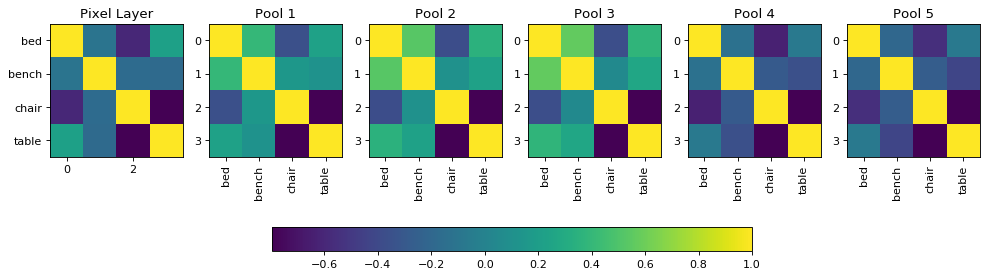

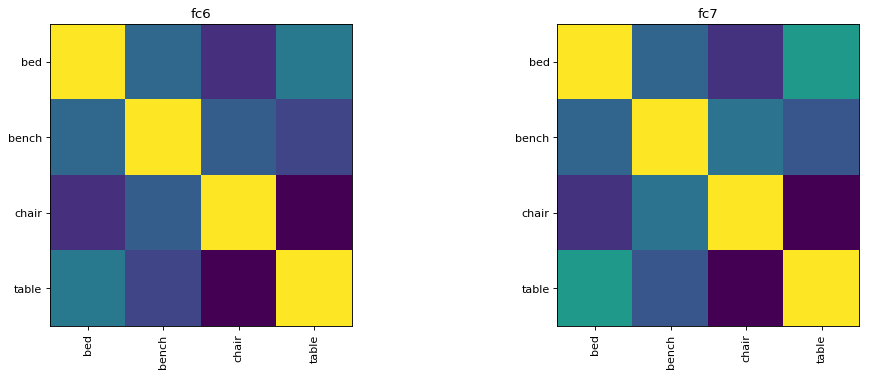

In [22]:
plot_all_RDM(RDM_S)

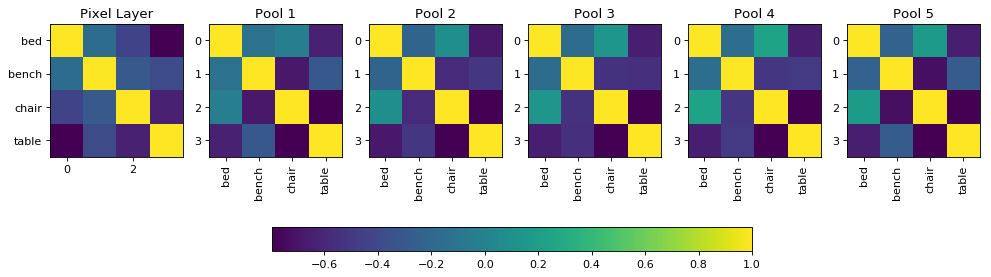

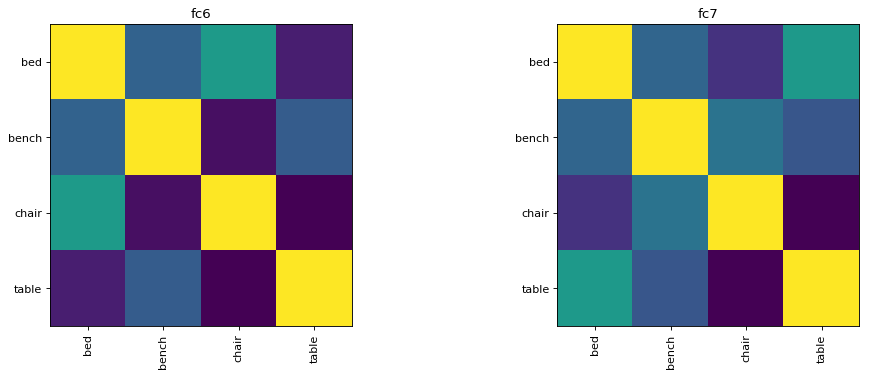

In [25]:
plot_all_RDM(RDM_D)

In [26]:
raw_diff = []
for layer in xrange(0,8):
    raw_diff.append(np.mean(abs(RDM_S[layer] - RDM_D[layer])))

In [27]:
between_domains = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(RDM_S[layer].flatten(), RDM_D[layer].flatten())
    between_domains.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is 0.845511099192
pearson coefficient for between domains for layer 1 is 0.795102288813
pearson coefficient for between domains for layer 2 is 0.704676318691
pearson coefficient for between domains for layer 3 is 0.698882022685
pearson coefficient for between domains for layer 4 is 0.831305899251
pearson coefficient for between domains for layer 5 is 0.842236474075
pearson coefficient for between domains for layer 6 is 0.716795653567
pearson coefficient for between domains for layer 7 is 0.747407064534


In [ ]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain")
plt.plot(xrange(8), between_domains)
plt.xlabel('Layers')
plt.ylabel('Performance')

x_label = LAYERS_NM
x_label.insert(0, "pixels")

plt.xticks(xrange(0,len(LAYERS) + 1), x_label);


In [ ]:

layer_score = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, _SF[i], _SL, cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score.append(scores.mean) 


clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
layer_score.append()
layer_score = reversed(layer_score)


Accuracy for layer 6.000000: 0.87 (+/- 0.05)
Accuracy for layer 5.000000: 0.88 (+/- 0.06)


In [ ]:
# single train/test split

for i in reversed(xrange(0,7)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        _SF[i], LABELS, test_size=0.2, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print("Score for single trial is %0.2f" % clf.score(X_test, y_test))

clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
layer_score.append()
layer_score = reversed(layer_score)